In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Devise

see Devise: A deep visual-semantic embedding model (2013) Frome, Andrea; Corrado, Gs; Shlens, Jonathon
    
    "In this paper we present a new deep visual-semantic embedding model trained to identify visual objects using both labeled image data as well as seman- tic information gleaned from unannotated text"

![title](nb_img/frome_etal_devise_2013.png)

Here we are using Tiny ImageNet instead of the much larger ImageNet dataset

https://tiny-imagenet.herokuapp.com/
    
"Tiny Imagenet has 200 classes. Each class has 500 training images, 50 validation images, and 50 test images."

In [2]:
from fastai.conv_learner import *
torch.backends.cudnn.benchmark=True

import fastText as ft

In [3]:
import torchvision.transforms as transforms

In [24]:
import fastai
from fastai.io import get_data

In [ ]:
See first part of pascal_tiny_imagenet for formatting tiny-imagenet dataset into format reqi

In [5]:
#Normalize an tensor image with mean and standard deviation, this transform will normalize each channel of the input
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

tfms = transforms.Compose([
    transforms.RandomSizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

/home/walle/anaconda3/envs/fastai/lib/python3.6/site-packages/torchvision/transforms/transforms.py:397: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")


In [150]:
PATH = Path('..')/'data/tiny-imagenet/tiny-imagenet-200'
TMP_PATH = PATH/'tmp'
PATH_TRN = PATH/'train'
PATH_VALID = PATH/'valid'
TRANS_PATH = Path('..')/'data/translate/fastText'

In [109]:
code_words = {}

with open(PATH/'words.txt') as f:
  for row in csv.reader(f, delimiter="\t"):
    #We keep only the first of the descriptions
    code = row[1].split(",")[0]
    #replace whitespaces with underscore
    #code = "_".join(code.split()).strip().lower()
    code_words[row[0]] = code
    
wnids = [line.strip() for line in open(PATH/'wnids.txt', 'r')]
#eg ['n02124075', 'n04067472', 'n04540053',...]

#keep only those words from our images
code_words = {k: code_words[k] for k in wnids}

tiny_df = pd.DataFrame(list(code_words.items()))

import json

with open(TMP_PATH/'tinyimagenet_class_index.json', 'w') as f:
    json.dump(tiny_df.T.to_dict(orient='list'), f)

In [285]:
#move all filess in tiny-imagenet-200/train/n0000/images/ to tiny-imagenet-200/train/n0000/
'''
for root, dirs, files in os.walk(PATH_TRN):
    for dr in dirs:
        if dr == "images":
            dr = root+"/"+dr
            # direct superior directory
            up = dr[:dr.rfind("/")]
            # move files from lowest level one level up
            for f in os.listdir(dr):
                shutil.move(dr+"/"+f, up+"/"+f)
'''

'\nfor root, dirs, files in os.walk(PATH_TRN):\n    for dr in dirs:\n        if dr == "images":\n            dr = root+"/"+dr\n            # direct superior directory\n            up = dr[:dr.rfind("/")]\n            # move files from lowest level one level up\n            for f in os.listdir(dr):\n                shutil.move(dr+"/"+f, up+"/"+f)\n'

In [284]:
#clean up 
'''
for root, dirs, files in os.walk(PATH_TRN):
    for dr in dirs:
        if dr == "images":
            os.rmdir(os.path.join(root, dr))       
'''

'\nfor root, dirs, files in os.walk(PATH_TRN):\n    for dr in dirs:\n        if dr == "images":\n            os.rmdir(os.path.join(root, dr))       \n'

In [283]:
#create a 10% validation set from the training data -commeted out so I dont accidently run again
'''
for root, dirs, files in os.walk(PATH_TRN):
    for dr in dirs:
        dir_pth = os.path.join(root, dr)
        val_img_path = os.path.join(PATH_VALID, dr)
        if not os.path.exists(val_img_path):
            os.makedirs(val_img_path)
        train_images = []
        for file in os.listdir(dir_pth):
            if file.endswith(".JPEG"):
                train_images.append(file)
        sub_files = random.sample(train_images, 50)
        for sub_file in sub_files:
            shutil.move(os.path.join(dir_pth, sub_file), val_img_path)
            #print(f'{os.path.join(root, sub_file)} ')
'''

'\nfor root, dirs, files in os.walk(PATH_TRN):\n    for dr in dirs:\n        dir_pth = os.path.join(root, dr)\n        val_img_path = os.path.join(PATH_VALID, dr)\n        if not os.path.exists(val_img_path):\n            os.makedirs(val_img_path)\n        train_images = []\n        for file in os.listdir(dir_pth):\n            if file.endswith(".JPEG"):\n                train_images.append(file)\n        sub_files = random.sample(train_images, 50)\n        for sub_file in sub_files:\n            shutil.move(os.path.join(dir_pth, sub_file), val_img_path)\n            #print(f\'{os.path.join(root, sub_file)} \')\n'

In [282]:
#move .txt files -commeted out so I dont accidently run again
'''
META_PATH = PATH/'train_meta'
#create a 10% validation set from the training data
for root, dirs, files in os.walk(PATH_TRN):
    for dr in dirs:
        dir_pth = os.path.join(root, dr)
        for file in os.listdir(dir_pth):
            if file.endswith(".txt"):
                shutil.move(os.path.join(dir_pth, file), META_PATH)
'''

'\nMETA_PATH = PATH/\'train_meta\'\n#create a 10% validation set from the training data\nfor root, dirs, files in os.walk(PATH_TRN):\n    for dr in dirs:\n        dir_pth = os.path.join(root, dr)\n        for file in os.listdir(dir_pth):\n            if file.endswith(".txt"):\n                shutil.move(os.path.join(dir_pth, file), META_PATH)\n'

In [164]:
fname = 'train/n01443537/n01443537_0.JPEG'

In [165]:
img = Image.open(PATH/fname)

In [166]:
fastai.dataloader.DataLoader

fastai.dataloader.DataLoader

In [167]:
#note resnet50 rather than 34
arch=resnet50
sz = 64
ttfms,vtfms = tfms_from_model(arch, sz, transforms_side_on, max_zoom=1.1)
def to_array(x,y): return np.array(x).astype(np.float32)/255,None
def TT(x,y): return torch.from_numpy(x),None

ttfms.tfms = [to_array] + ttfms.tfms# + [TT]

In [168]:
ttfms(img)

array([[[ 0.22693,  1.69046,  1.70831, ...,  2.24891,  2.24891,  2.24891],
        [ 0.15554,  1.56553,  1.61907, ...,  2.24891,  2.24891,  2.24891],
        [ 0.11985,  1.56553,  1.69046, ...,  2.24891,  2.24891,  2.24891],
        ...,
        [-0.32635, -0.61192, -0.48698, ..., -0.3442 , -0.3442 , -0.32635],
        [-0.45129, -0.62977, -0.46914, ..., -0.45129, -0.43344, -0.41559],
        [-0.71901, -0.62977, -0.29066, ..., -0.3799 , -0.3799 , -0.3799 ]],

       [[ 1.07307,  2.42857,  2.40505, ...,  0.78113,  0.61691,  0.58042],
        [ 1.00008,  2.36856,  2.31382, ...,  0.58042,  0.4162 ,  0.34322],
        [ 0.9271 ,  2.36856,  2.33207, ...,  0.52568,  0.39796,  0.34322],
        ...,
        [-0.40488, -0.69682, -0.5691 , ...,  0.19725,  0.25198,  0.30672],
        [-0.53261, -0.71507, -0.55085, ...,  0.14251,  0.19725,  0.23374],
        [-0.8063 , -0.71507, -0.36839, ...,  0.21549,  0.25198,  0.27023]],

       [[ 1.23603,  2.64   ,  2.58026, ...,  1.88998,  1.79915,  1.799

In [169]:
ft_vecs = ft.load_model(str((TRANS_PATH/'wiki.en.bin')))

In [170]:
ft_vecs.get_word_vector('king')

array([ 0.03259, -0.18164, -0.29049, -0.10506, -0.16712, -0.07748, -0.5661 , -0.08622, -0.00216,  0.15366,
        0.12189, -0.14722,  0.01511,  0.07209, -0.02156, -0.20612, -0.02104, -0.01999, -0.15506,  0.00802,
       -0.22746,  0.33518, -0.10629, -0.50318, -0.1582 ,  0.27829,  0.05752, -0.32697,  0.04766,  0.01076,
        0.13972, -0.12445, -0.18989,  0.32969, -0.32513,  0.10958,  0.21962, -0.47215,  0.03422, -0.2207 ,
        0.02177,  0.0832 , -0.04776, -0.48873,  0.05207, -0.15001, -0.19203,  0.06177,  0.15535, -0.05598,
        0.11071,  0.39161, -0.17716,  0.05449,  0.25898, -0.13954,  0.4272 , -0.07273, -0.4714 ,  0.04993,
        0.29526, -0.05319,  0.03451, -0.10583, -0.30137,  0.16372,  0.07541,  0.21018, -0.11459,  0.10976,
        0.04923,  0.17688,  0.45658, -0.59762, -0.0039 ,  0.08866,  0.53103,  0.153  , -0.1673 ,  0.13121,
       -0.05547, -0.03582, -0.34535,  0.09128,  0.03323,  0.45211, -0.16894,  0.21139,  0.24153,  0.51014,
       -0.01474, -0.47179,  0.2235 , 

In [171]:
np.corrcoef(ft_vecs.get_word_vector('Apple'), ft_vecs.get_word_vector('Watermelon'))

array([[1.     , 0.30161],
       [0.30161, 1.     ]])

In [172]:
np.corrcoef(ft_vecs.get_word_vector('cat'), ft_vecs.get_word_vector('frog'))

array([[1.    , 0.3457],
       [0.3457, 1.    ]])

## Map imagenet classes to word vectors¶

In [203]:
ft_words = ft_vecs.get_words(include_freq=True)
ft_word_dict = {k:v for k,v in zip(*ft_words)}
ft_words = sorted(ft_word_dict.keys(), key=lambda x: ft_word_dict[x])

len(ft_words)

2519370

In [204]:
#see raw cell above for how to generate this file
CLASSES_FN = 'tinyimagenet_class_index.json'
#get_data(f'http://files.fast.ai/models/{CLASSES_FN}', TMP_PATH/CLASSES_FN)

In [205]:
#assuming imagenet and tiny imagenet share same classes
WORDS_FN = 'classids.txt'
get_data(f'http://files.fast.ai/data/{WORDS_FN}', PATH/WORDS_FN)

In [206]:
class_dict = json.load((TMP_PATH/CLASSES_FN).open())
classids_1k = dict(class_dict.values())
nclass = len(class_dict); nclass

200

In [207]:
class_dict['100']

['n01945685', 'slug']

In [208]:
classid_lines = (PATH/WORDS_FN).open().readlines()
classid_lines[:5]

['n00001740 entity\n',
 'n00001930 physical_entity\n',
 'n00002137 abstraction\n',
 'n00002452 thing\n',
 'n00002684 object\n']

In [209]:
classids = dict(l.strip().split() for l in classid_lines)
#fwikiword count, imagenet class count
len(classids),len(classids_1k)

(82115, 200)

In [210]:
lc_vec_d = {w.lower(): ft_vecs.get_word_vector(w) for w in ft_words[-1000000:]}

In [211]:
syn_wv = [(k, lc_vec_d[v.lower()]) for k,v in classids.items()
          if v.lower() in lc_vec_d]
syn_wv_1k = [(k, lc_vec_d[v.lower()]) for k,v in classids_1k.items()
          if v.lower() in lc_vec_d]
syn2wv = dict(syn_wv)
len(syn2wv)

49469

In [212]:
pickle.dump(syn2wv, (TMP_PATH/'syn2wv.pkl').open('wb'))
pickle.dump(syn_wv_1k, (TMP_PATH/'syn_wv_1k.pkl').open('wb'))

In [213]:
syn2wv = pickle.load((TMP_PATH/'syn2wv.pkl').open('rb'))
syn_wv_1k = pickle.load((TMP_PATH/'syn_wv_1k.pkl').open('rb'))

In [214]:
#syn2wv: {'n00001740': array([ 0.02561,  0.17057, -0.12382,  0.3527 , -0.06303,  0.08731,  0.14308, -0.32462, -0.31296,  0.09208,
#syn_wv_1k: [('n04067472', array([ 0.18304,  0.14933,  0.02282, -0.0666 , -0.1051 ,  0.18766,  0.09269,  0.33658, -0.03494,  0.06966,

In [215]:
images = []
img_vecs = []

n_trn=0
for d in (PATH/'train').iterdir():
    if d.name not in syn2wv: continue
    vec = syn2wv[d.name]
    for f in d.iterdir():
        images.append(str(f.relative_to(PATH)))
        img_vecs.append(vec)
        n_trn += 1

n_val=0
for d in (PATH/'valid').iterdir():
    if d.name not in syn2wv: continue
    vec = syn2wv[d.name]
    for f in d.iterdir():
        images.append(str(f.relative_to(PATH)))
        img_vecs.append(vec)
        n_val += 1

In [216]:
n_trn, n_val

(54900, 6100)

In [217]:
img_vecs = np.stack(img_vecs)
img_vecs.shape

(61000, 300)

In [218]:
pickle.dump(images, (TMP_PATH/'images.pkl').open('wb'))
pickle.dump(img_vecs, (TMP_PATH/'img_vecs.pkl').open('wb'))

In [219]:
images = pickle.load((TMP_PATH/'images.pkl').open('rb'))
img_vecs = pickle.load((TMP_PATH/'img_vecs.pkl').open('rb'))

In [220]:
arch = resnet50

In [221]:
n = len(images); n

61000

In [222]:
val_idxs = list(range(n-6100, n))

In [223]:
#tiny imagenet files are 64x64 pixels
sz = 64

In [224]:
tfms = tfms_from_model(arch, sz, transforms_side_on, max_zoom=1.1)
md = ImageClassifierData.from_names_and_array(PATH, images, img_vecs, val_idxs=val_idxs,
        classes=None, tfms=tfms, continuous=True, bs=256)

In [225]:
x,y = next(iter(md.val_dl))

In [226]:
models = ConvnetBuilder(arch, md.c, is_multi=False, is_reg=True, xtra_fc=[1024], ps=[0.2,0.2])

learn = ConvLearner(md, models, precompute=True)
learn.opt_fn = partial(optim.Adam, betas=(0.9,0.99))


100%|██████████| 24/24 [00:02<00:00,  8.64it/s]


In [227]:
def cos_loss(inp,targ): 
    return 1 - F.cosine_similarity(inp,targ).mean()

learn.crit = cos_loss

In [228]:
learn.lr_find(start_lr=1e-4, end_lr=1e15)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   
    0      0.392282   1.0       



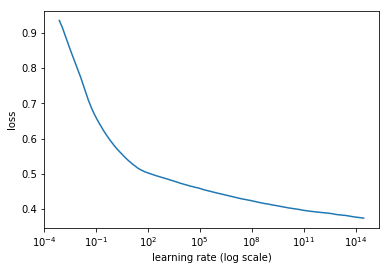

In [229]:
learn.sched.plot()

In [230]:
lr = 1e-2
wd = 1e-7

In [231]:
learn.precompute=True

In [232]:
vals, ep_vals = learn.fit(lr, 1, cycle_len=20, wds=wd, use_clr=(20,10), get_ep_vals=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=20), HTML(value='')))

epoch      trn_loss   val_loss   
    0      0.355904   0.320263  
    1      0.314374   0.299172  
    2      0.295476   0.283435  
    3      0.285279   0.278514  
    4      0.268739   0.274216  
    5      0.260791   0.269208  
    6      0.250633   0.269192  
    7      0.243678   0.268941  
    8      0.239409   0.270869  
    9      0.230458   0.267678  
    10     0.223445   0.266986  
    11     0.216343   0.26638   
    12     0.209913   0.265014  
    13     0.203199   0.266233  
    14     0.198578   0.266404  
    15     0.194644   0.265354  
    16     0.187537   0.265532  
    17     0.181828   0.266868  
    18     0.179789   0.268682  
    19     0.174339   0.266913  



In [233]:
def plot_ep_vals(ep_vals):
    plt.ylabel("loss")
    plt.xlabel("epoch")
    epochs = ep_vals.keys()
    plt.xticks(np.asarray(list(epochs)))
    trn_losses = [item[0] for item in list(ep_vals.values())]
    val_losses = [item[1] for item in list(ep_vals.values())]
    plt.plot(epochs, trn_losses, c='b', label='train')
    plt.plot(epochs, val_losses, c='r', label='validation')
    plt.legend(loc='upper left')

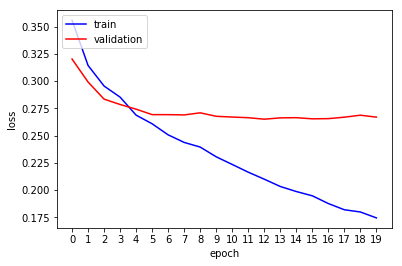

In [234]:
plot_ep_vals(ep_vals)

The validation loss is over double the loss at this stage for imagenet in the lesson notebook - but tiny imagenet is more challenging, seems reasonable.

In [235]:
learn.bn_freeze(True)

In [236]:
vals, ep_vals = learn.fit(lr, 1, cycle_len=20, wds=wd, use_clr=(20,10), get_ep_vals=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=20), HTML(value='')))

epoch      trn_loss   val_loss   
    0      0.167443   0.266617  
    1      0.186888   0.272598  
    2      0.194501   0.272539  
    3      0.18479    0.272469  
    4      0.178571   0.271527  
    5      0.171869   0.270316  
    6      0.165589   0.272211  
    7      0.157313   0.27516   
    8      0.152532   0.27514   
    9      0.148474   0.274044  
    10     0.140031   0.276757  
    11     0.132909   0.279221  
    12     0.127865   0.275707  
    13     0.123374   0.27884   
    14     0.119287   0.280992  
    15     0.11533    0.280547  
    16     0.111433   0.282864  
    17     0.107604   0.283394  
    18     0.105052   0.281663  
    19     0.102262   0.282892  



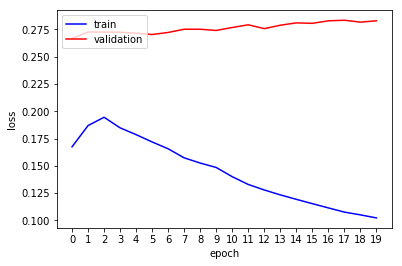

In [237]:
plot_ep_vals(ep_vals)

Validation loss is increasing

TODO revsit this to reduce overfitting - try more dropout

In [238]:
lrs = np.array([lr/1000,lr/100,lr])

In [239]:
learn.precompute=False
learn.freeze_to(1)

In [240]:
learn.save('pre0')

In [241]:
learn.load('pre0')

## Image Search

Search imagenet classes

In [246]:
syns, wvs = list(zip(*syn_wv_1k))
wvs = np.array(wvs)

In [247]:
%time pred_wv = learn.predict()

CPU times: user 6.74 s, sys: 5.02 s, total: 11.8 s
Wall time: 1.58 s


In [248]:
start=300

In [249]:
denorm = md.val_ds.denorm

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.axis('off')
    return ax

def show_imgs(ims, cols, figsize=None):
    fig,axes = plt.subplots(len(ims)//cols, cols, figsize=figsize)
    for i,ax in enumerate(axes.flat): show_img(ims[i], ax=ax)
    plt.tight_layout()

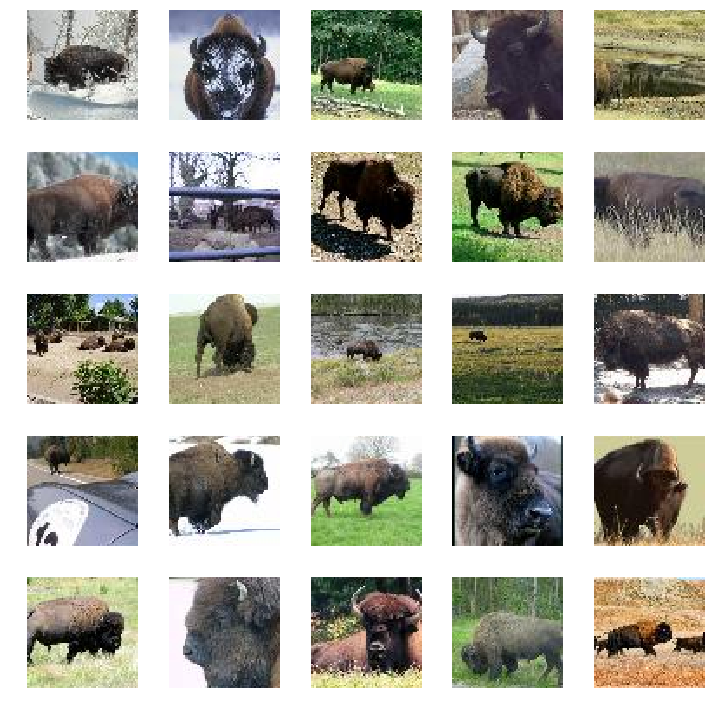

In [250]:
show_imgs(denorm(md.val_ds[start:start+25][0]), 5, (10,10))

In [252]:
#pip install nmslib #this take a good few minutes
import nmslib

def create_index(a):
    index = nmslib.init(space='angulardist')
    index.addDataPointBatch(a)
    index.createIndex()
    return index

def get_knns(index, vecs):
     return zip(*index.knnQueryBatch(vecs, k=10, num_threads=4))

def get_knn(index, vec): return index.knnQuery(vec, k=10)

In [253]:
nn_wvs = create_index(wvs)

In [254]:
idxs,dists = get_knns(nn_wvs, pred_wv)

In [255]:
[[classids[syns[id]] for id in ids[:3]] for ids in idxs[start:start+10]]

[['cockroach', 'tarantula', 'mantis'],
 ['stopwatch', 'scoreboard', 'binoculars'],
 ['bison', 'bighorn', 'ox'],
 ['chimpanzee', 'bison', 'orangutan'],
 ['bison', 'bighorn', 'cougar'],
 ['bison', 'bighorn', 'cougar'],
 ['lakeside', 'cliff', 'seashore'],
 ['bison', 'bighorn', 'cougar'],
 ['bison', 'bighorn', 'cougar'],
 ['bison', 'bighorn', 'lion']]

### Search all wordnet noun classes

In [256]:
all_syns, all_wvs = list(zip(*syn2wv.items()))
all_wvs = np.array(all_wvs)

In [257]:
nn_allwvs = create_index(all_wvs)

In [258]:
idxs,dists = get_knns(nn_allwvs, pred_wv)

In [259]:
[[classids[all_syns[id]] for id in ids[:3]] for ids in idxs[start:start+10]]

[['cockroach', 'housefly', 'termite'],
 ['stopwatch', 'wristwatch', 'timer'],
 ['bison', 'pronghorn', 'deer'],
 ['chimpanzee', 'bison', 'orangutan'],
 ['bison', 'pronghorn', 'deer'],
 ['bison', 'pronghorn', 'deer'],
 ['lakeside', 'lake', 'lake'],
 ['bison', 'pronghorn', 'deer'],
 ['bison', 'pronghorn', 'deer'],
 ['bison', 'pronghorn', 'deer']]

### Text -> image search

In [260]:
nn_predwv = create_index(pred_wv)

In [261]:
en_vecd = pickle.load(open(TRANS_PATH/'wiki.en.pkl','rb'))

In [262]:
vec = en_vecd['boat']

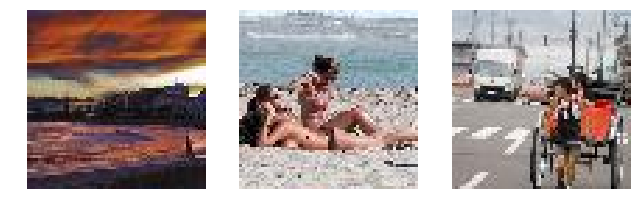

In [263]:
idxs,dists = get_knn(nn_predwv, vec)
show_imgs([open_image(PATH/md.val_ds.fnames[i]) for i in idxs[:3]], 3, figsize=(9,3))

In [264]:
vec = (en_vecd['engine'] + en_vecd['boat'])/2

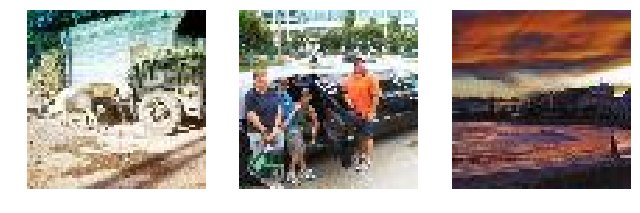

In [265]:
idxs,dists = get_knn(nn_predwv, vec)
show_imgs([open_image(PATH/md.val_ds.fnames[i]) for i in idxs[:3]], 3, figsize=(9,3))

In [266]:
vec = (en_vecd['sail'] + en_vecd['boat'])/2

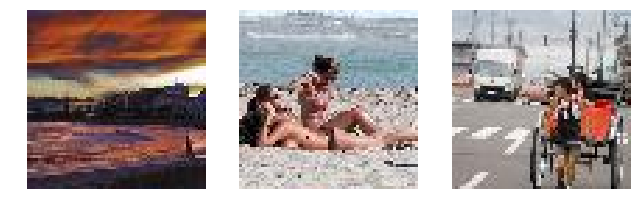

In [267]:
idxs,dists = get_knn(nn_predwv, vec)
show_imgs([open_image(PATH/md.val_ds.fnames[i]) for i in idxs[:3]], 3, figsize=(9,3))

### Image->image

In [273]:
fname = 'valid/n02395406/n02395406_433.JPEG'

In [274]:
img = open_image(PATH/fname)

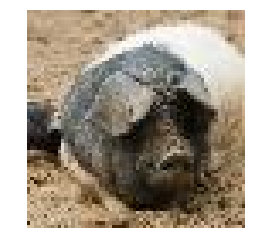

In [275]:
show_img(img);

In [276]:
t_img = md.val_ds.transform(img)
pred = learn.predict_array(t_img[None])

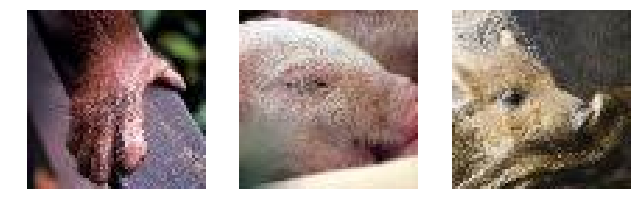

In [277]:
idxs,dists = get_knn(nn_predwv, pred)
show_imgs([open_image(PATH/md.val_ds.fnames[i]) for i in idxs[1:4]], 3, figsize=(9,3));

Hmmm, maybe not as accurate as imagenet but not too bad...